In [11]:
import tensorflow as tf

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

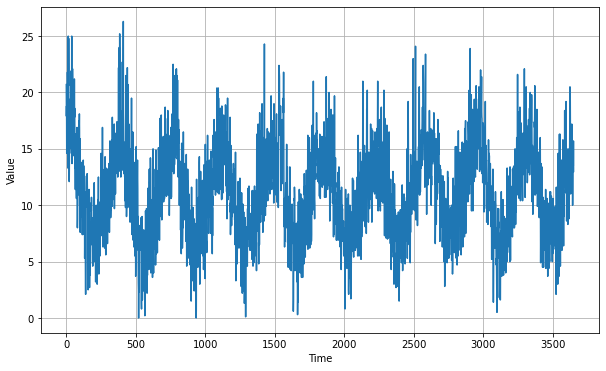

In [6]:
import csv


time_step = []
temps = []

# Create data with time is index, and temperature is read from csv file
with open("data/temperature/daily-min-temperatures.csv") as csvfile:
    rows = csv.reader(csvfile)
    next(rows)
    for index,temp in enumerate(rows):
        time_step.append(index)
        temps.append(float(temp[1]))


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [12]:
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=[None,1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 1s 117ms/step - loss: 76.4749 - mae: 76.9740
Epoch 2/100
10/10 [==============================] - 1s 115ms/step - loss: 75.7808 - mae: 76.2799
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 74.7219 - mae: 75.2210
Epoch 4/100
10/10 [==============================] - 1s 114ms/step - loss: 73.4382 - mae: 73.9373
Epoch 5/100
10/10 [==============================] - 1s 121ms/step - loss: 71.9668 - mae: 72.4661
Epoch 6/100
10/10 [==============================] - 1s 116ms/step - loss: 70.3075 - mae: 70.8069
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 68.4475 - mae: 68.9469
Epoch 8/100
10/10 [==============================] - 1s 113ms/step - loss: 66.3658 - mae: 66.8653
Epoch 9/100
10/10 [==============================] - 1s 111ms/step - loss: 64.0357 - mae: 64.5353
Epoch 10/100
10/10 [==============================] - 1s 116ms/step - loss: 61.4284 - mae: 61.9281
Epoch 11/100
10/10 

10/10 [==============================] - 1s 107ms/step - loss: 4.8689 - mae: 5.3583
Epoch 86/100
10/10 [==============================] - 1s 107ms/step - loss: 4.8355 - mae: 5.3223
Epoch 87/100
10/10 [==============================] - 1s 105ms/step - loss: 15.2714 - mae: 15.7650
Epoch 88/100
10/10 [==============================] - 1s 107ms/step - loss: 13.9668 - mae: 14.4626
Epoch 89/100
10/10 [==============================] - 1s 113ms/step - loss: 8.1944 - mae: 8.6894
Epoch 90/100
10/10 [==============================] - 1s 111ms/step - loss: 7.8688 - mae: 8.3659
Epoch 91/100
10/10 [==============================] - 1s 119ms/step - loss: 7.2880 - mae: 7.7833
Epoch 92/100
10/10 [==============================] - 1s 111ms/step - loss: 7.6857 - mae: 8.1822
Epoch 93/100
10/10 [==============================] - 1s 107ms/step - loss: 8.0186 - mae: 8.5153
Epoch 94/100
10/10 [==============================] - 1s 121ms/step - loss: 8.7875 - mae: 9.2852
Epoch 95/100
10/10 [===================

(1e-08, 0.0001, 0.0, 60.0)

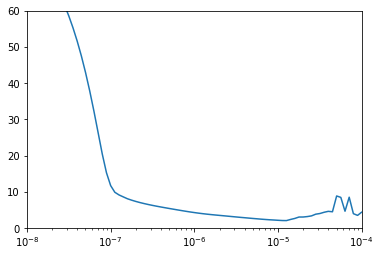

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=[None,1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 57ms/step - loss: 14.6766 - mae: 15.1694
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 3.2366 - mae: 3.7080
Epoch 3/100
25/25 [==============================] - 1s 55ms/step - loss: 2.1662 - mae: 2.6235
Epoch 4/100
25/25 [==============================] - 1s 55ms/step - loss: 1.9612 - mae: 2.4145
Epoch 5/100
25/25 [==============================] - 1s 55ms/step - loss: 1.8938 - mae: 2.3461
Epoch 6/100
25/25 [==============================] - 1s 55ms/step - loss: 1.8582 - mae: 2.3096
Epoch 7/100
25/25 [==============================] - 1s 55ms/step - loss: 1.8292 - mae: 2.2804: 0s - loss: 1.9
Epoch 8/100
25/25 [==============================] - 1s 58ms/step - loss: 1.8045 - mae: 2.2548
Epoch 9/100
25/25 [==============================] - 1s 55ms/step - loss: 1.7836 - mae: 2.2337
Epoch 10/100
25/25 [==============================] - 1s 56ms/step - loss: 1.7620 - mae: 2.2109
Epoch 11/100
25/25 [===========

25/25 [==============================] - 1s 53ms/step - loss: 1.4967 - mae: 1.9371
Epoch 86/100
25/25 [==============================] - 1s 54ms/step - loss: 1.4997 - mae: 1.9404: 0s - loss: 1.5050 - mae: 1.9
Epoch 87/100
25/25 [==============================] - 1s 56ms/step - loss: 1.5004 - mae: 1.9411
Epoch 88/100
25/25 [==============================] - 1s 56ms/step - loss: 1.4987 - mae: 1.9393
Epoch 89/100
25/25 [==============================] - 1s 55ms/step - loss: 1.4994 - mae: 1.9402
Epoch 90/100
25/25 [==============================] - 1s 53ms/step - loss: 1.4954 - mae: 1.9358
Epoch 91/100
25/25 [==============================] - 1s 53ms/step - loss: 1.4965 - mae: 1.9371
Epoch 92/100
25/25 [==============================] - 2s 61ms/step - loss: 1.4948 - mae: 1.9354
Epoch 93/100
25/25 [==============================] - 1s 55ms/step - loss: 1.5013 - mae: 1.9423
Epoch 94/100
25/25 [==============================] - 1s 55ms/step - loss: 1.4965 - mae: 1.9370: 0s - loss: 1.
Epoch 95

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

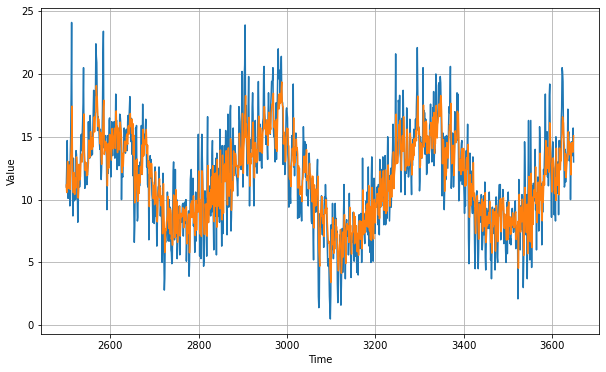

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)